Your owe a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $a_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h(s)$ for $s$ units in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $C(a)$ for $a$ units
  * Sales profit: $f(q)$ for $q$ units sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $A_t$ bikes,
$$X_t = - C(A_t) - h(S_t) + f\big(\min(D_t, S_t+A_t, M) \big)$$
* Transitions: you end the week with $S_{t+1} = \max\big(0, \min(M, S_t + A_t)  - D_t \big)$ bikes

Here we assume that $h(s) = h\cdot s$, $f(q) = p\cdot q$, $C(a) = c_0 \mathbb{1}\{a>0\} + c\cdot a$

In [1]:
# Initialization

## Loading useful packages
using LinearAlgebra
using Statistics
# using StatsBase
using Plots

## Constants of the problem
M = 15 # stock capacity
h = 0.3 # maintenance cost per unit and per week-end
p = 1 # selling price per unit
c0 = 0.8 # shpping cost per command
c = 0.5 # buying price per unit

s0 = M # initial stock
gamma = 0.99 # discount factor: I do not care what happens after more than 100 weeks (but in fact the optimal policy has a limit when gamma tends to 1)

## The demand 

avgdem = 9 # average demand
# demande distribution function (everything >=M is grouped together since at most M bikes can be sold anyway)
# pdem = [exp(-avgdem) * avgdem^(big(k)) / factorial(big(k)) for k in 0:M] # Poisson demand (small tail)
pdem = [1/(1+avgdem)*(1-1/(1+avgdem))^k for k in 0:M]# Exponential demand (large tail)
pdem[M+1] = 1 - sum(pdem[1:M])
cpdem = cumsum(pdem)
function rdemand()
    u = rand()# random demand generator
    return( sum([u>cpdem[k] for k in 1:(M+1)]) )
end

rdemand (generic function with 1 method)

In [2]:
# Transition and Reward functions

function reward(s, a, d)
   return( -h*(s) -c0*(a>0) - c*a + p * min(d, s+a, M) )
end

function nextState(s, a, d)
    return( max(0, min(M, s+a)-d) )
end

function simu(T, pi)
    X = zeros(T+1)
    S = s0
    for t in 0:T
        A = pi(S)
        D = rdemand()
        X[1+t] = reward(S, A, D)
        S = nextState(S, A, D)
    end
    return(X)
end

simu (generic function with 1 method)

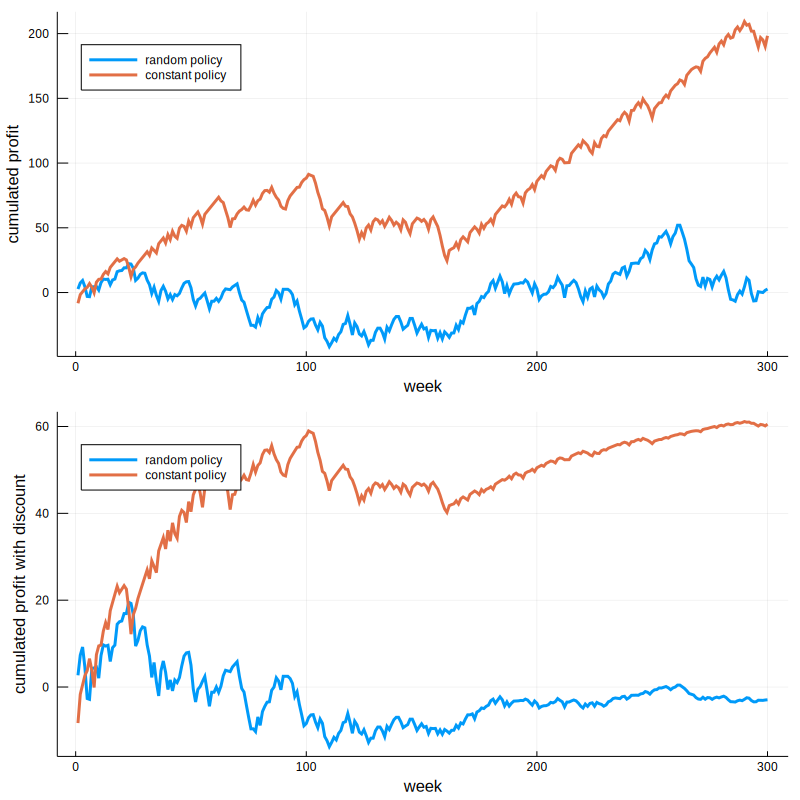

In [3]:
# Simulation: comparing two (basic) policies

function randomPolicy(s)
    return( rand(0:M) )
end

function constantPolicy(s)
    return(6)
end

T = trunc(Int, 3/(1-gamma))
X1 = simu(T, randomPolicy)
X2 = simu(T, constantPolicy)


# without discount:
p1 = plot([cumsum(X1), cumsum(X2)], xlabel = "week", ylabel = "cumulated profit", label=["random policy" "constant policy"], legend=:topleft, lw=3)

# with discount:
p2 = plot([cumsum(X1 .* [gamma^t for t in 0:T]), cumsum(X2.* [gamma^t for t in 0:T])], xlabel = "week", ylabel = "cumulated profit with discount", label=["random policy" "constant policy"], legend=:topleft, lw=3)

plot(p1, p2, layout = (2,1), size = (800, 800))
#png("shop_run_profit.png")


In [4]:
# Transition and Reward kernels
K = Dict() # K[s,a][ns] = probability to skip from state s to state ns for the action a
avgR = Dict() # avgR[s,a] = average reward received in state s when playing action a

## initialization
for a in 0:M
    for s in 0:M
        K[s,a] = zeros(1+M)
        avgR[s,a] = 0
    end
end

## computation: iterate over all possible states, actions, and possible demand values
for a in 0:M
    for s in 0:M
        for d in 0:M
            ns = nextState(s, a, d); 
            K[s,a][1+ns] += pdem[1+d]
            avgR[s,a] += pdem[1+d] * reward(s, a, d)
        end
    end
end

In [5]:
# Markov transition matrix of a *deterministic* policy pi

function policyTransitionMatrix(pi) # warning: requires pi to be *deterministic*
    Kpi = zeros(1+M, 1+M)
    for s in 0:M
        Kpi[1+s,:] = K[s, pi(s)]
    end
    return(Kpi)
end

function policyAvgReward(pi)
    avgRpi = zeros(1+M)
    for s in 0:M
        avgRpi[1+s] = avgR[s, pi(s)]
    end
    return(avgRpi)
end
  
# example: for the constant policy
# Kpi = policyTransitionMatrix(constantPolicy)
# avgRpi = policyAvgReward(constantPolicy)

# policy evaluation

function evaluatePolicy(pi)
    Kpi = policyTransitionMatrix(pi)
    avgRpi = policyAvgReward(pi)
    return( (Matrix{Float64}(I, M+1, M+1) - gamma * Kpi) \ avgRpi )
end

evaluatePolicy(constantPolicy)

16-element Array{Float64,1}:
 47.53820008510554 
 47.68531763137929 
 47.764349168493375
 47.77853042281694 
 47.73159355170817 
 47.629650367710276
 47.478201502112164
 47.282197523073876
 47.0460939419394  
 46.77390071891838 
 46.47390071891839 
 46.17390071891838 
 45.87390071891838 
 45.573900718918374
 45.27390071891837 
 44.97390071891837 

# Planning

In [23]:
# Bellmann Operator
function BellmannOperator(V) # TODO maybe: merge BellmannOperator and greedyPolicy by having BellmannOperator return the associated policy
    nV = copy(V)    
    for s in 0:M
        nV[1+s] = maximum([avgR[s, a] + gamma * dot(K[s,a], V) for a in 0:M]) 
    end    
    return(nV)
end

# Value Iteration
function valueIteration(epsilon=1e-6) # epsilon = guaranteed precision
    V = zeros(1+M)  # in theory, can be anything
    oV = [v + 2*epsilon for v in V]
    while norm(V-oV, Inf) > epsilon*(1-gamma)/gamma
        oV = copy(V)
        V = BellmannOperator(V)
    end
    return(V)
end

function greedyPolicy(V)
    return([ findmax([avgR[s, a] + gamma * dot(K[s,a], V) for a in 0:M])[2]-1 for s in 0:M])
end

optimalValue = valueIteration()
print(optimalValue')
piOpt = greedyPolicy(optimalValue)'

[118.22 118.42 118.62 118.82 119.122 119.523 119.89 120.223 120.522 120.788 121.02 121.219 121.384 121.516 121.614 121.679]

1×16 Adjoint{Int64,Array{Int64,1}}:
 10  9  8  7  0  0  0  0  0  0  0  0  0  0  0  0

In [9]:
# Policy Iteration
function policyIteration()
    pi = rand(0:M, 1+M)
    opi = -ones(1+M)
    while any(pi!=opi)
        opi = copy(pi)
        V = evaluatePolicy(x->pi[1+x])
        pi = greedyPolicy(V)
    end
    return(pi)
end

policyIteration()'

1×16 Adjoint{Int64,Array{Int64,1}}:
 10  9  8  7  0  0  0  0  0  0  0  0  0  0  0  0

Kpi = zeros(1+M, 1+M)
Kpi[1+0, :] = K[(0, 0)]

In [10]:
# Linear Programming
# WARNING: packages JuMP and Convex are incompatible! only one of the two should be uncommented

### Using package JuMP
# using JuMP
# using Clp
# model = Model(solver = ClpSolver())
# @variable(model, V[s=0:M])
# @objective(model, Min, sum(V))
# #@constraint(model, con00, V[0] >= avgR[0, 0] + gamma * sum(K[0,0][1+k] * V[k] for k in 0:M) )
# @constraint(model, con[s=0:M, a=0:M], V[s] >= avgR[s, a] + gamma * sum(K[s, a][1+k] * V[k] for k in 0:M) )
# status = solve(model)
# piOpt = greedyPolicy(getvalue(V)[:])'

## Using Package Convex
using Convex
using SCS
solver = SCSSolver(verbose=0)
#set_default_solver(solver);

V = Variable(M+1)
convexPb = minimize(sum(V))
convexPb.constraints +=  [ V[1+s] >= avgR[s, a] + gamma * sum(K[s, a][1+k] * V[1+k] for k in 0:M) for s in 0:M, a in 0:M]
solve!(convexPb, solver)
piOpt = greedyPolicy(V.value)'

┌ Warning: Problem status UnknownError; solution may be inaccurate.
└ @ Convex /home/agarivie/.julia/packages/Convex/nR5LG/src/solution.jl:51


1×16 Adjoint{Int64,Array{Int64,1}}:
 10  9  8  7  0  0  0  0  0  0  0  0  0  0  0  0

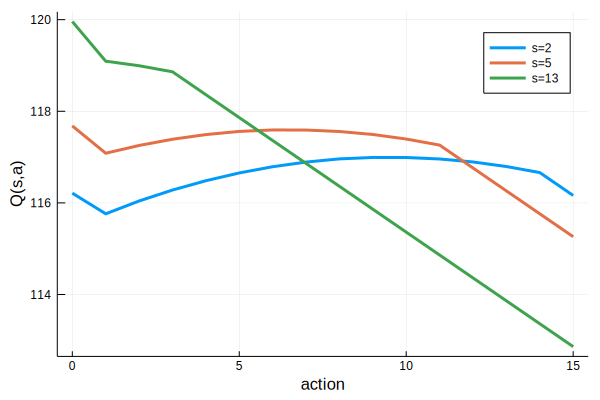

In [36]:
# computing the optimal Q-table
optimalQ = zeros(M+1, M+1)
for s in 0:M
    for a in 0:M
        optimalQ[1+s, 1+a]= avgR[s, a] + gamma * sum([K[s, a][1+ns] * V.value[1+ns] for ns in 0:M ])
    end
end

lS = [2, Int64(floor(M/3)), M-2]
plot(0:M, optimalQ[lS, :]',  xlabel = "action", ylabel = "Q(s,a)", label=[ string("s=", x) for x in lS], lw=3)


# Stochastic Approximation for Policy Evaluation: TD(0) and TD($\lambda$)

In [13]:
function TD0(pi, T)
    V = zeros(1+M) # V[S] = estimated value of each state under policy pi
    N = zeros(1+M) # N[S] =number of visits to state s in the loop
    S = s0
    for t in 1:T
        N[1+S] += 1
        A = pi(S)
        D = rdemand()
        X = reward(S, A, D)
        nS = nextState(S, A, D) 
        alpha = 1/(1+N[1+S])^0.5 
        V[1+S] = (1-alpha)*V[1+S] + alpha * (X + gamma*V[1+nS])
        S = nS
    end
    return(V)
end

T = 10^7
[TD0(constantPolicy, T)'; evaluatePolicy(constantPolicy)']'
# requires a huge number of iterations to converge... at least 10^7
# because the initialization is too far from the solution: it takes forever to raise from 0 to 47

16×2 Adjoint{Float64,Array{Float64,2}}:
 47.3413  47.5382
 47.511   47.6853
 47.6031  47.7643
 47.4968  47.7785
 47.489   47.7316
 47.4259  47.6297
 47.0499  47.4782
 47.0806  47.2822
 46.5944  47.0461
 46.4258  46.7739
 46.1666  46.4739
 45.9161  46.1739
 45.5645  45.8739
 45.4735  45.5739
 44.9925  45.2739
 45.1997  44.9739

# Model-free Learning: Q-learning

In [245]:
function Qlearning(T)
    # Q = zeros(1+M, 1+M) # Q-table
    Q = 118*ones(1+M, 1+M) # Q-table cheating with initialization
    N = zeros(1+M) # number of visits to state s # rather take state-value?
    epsilon = 0.3
    S = s0
    for t in 1:T
        if mod(t, floor(T/10))==0 print(Int64(100*t/T), "%\t"); if t==T println() end; flush(stdout) end       
        N[1+S] += 1
        if rand()<epsilon# /t^(1/4) # epsilon-greedy choice of action
            A = rand(0:M)
        else
            A = findmax(Q[1+S, :])[2]-1 # greedy action            
        end
        D = rdemand()
        X = reward(S, A, D)
        nS = nextState(S, A, D)
        delta = X + gamma * maximum(Q[1+nS, :]) - Q[1+S, 1+A]
        alpha = 1/(1+N[1+S])^0.5 # alpha = 1/t^0.3 # warning: alpha should not be taken for an integer...
        Q[1+S, 1+A] += alpha * delta
        S = nS        
    end;  
    pi = [findmax(Q[1+s,:])[2]-1  for s in 0:M] 
    println( [Q[1+s, 1+pi[1+s]] for s in 0:M] )
    return(pi)
end

T = 10^7
pi = Qlearning(T)
println(pi')
println(evaluatePolicy(s->pi[1+s])')
println(optimalValue')


# for T >= 10^7, we obtain correct policies
# for T >= 10^8, we almost obtain the right one

10%	20%	30%	40%	50%	60%	70%	80%	90%	100%	
[117.996, 118.13, 118.552, 118.673, 118.926, 119.383, 119.784, 120.051, 120.336, 120.495, 120.788, 120.985, 121.182, 121.325, 121.242, 121.404]
[11 11 8 5 0 0 0 0 0 0 0 0 0 0 0 0]
[117.488 117.654 117.888 117.989 118.386 118.787 119.155 119.489 119.789 120.055 120.288 120.488 120.654 120.786 120.885 120.951]
[118.22 118.42 118.62 118.82 119.122 119.523 119.89 120.223 120.522 120.788 121.02 121.219 121.384 121.516 121.614 121.679]


In [333]:
# minimalistic Neural Network
widths = [3 20 10 5 1]
depth = length(widths)
activation = [zeros(widths[k]) for k in 1:depth]
delta = copy(activation)
coefficients = [rand(widths[k+1], widths[k]).-1/2 for k in 1:(depth-1)]

# sigma(x) = [1/(1+exp(-u)) for u in x]; dsigma(x) = [exp(-u)/(1+exp(-u))^2 for u in x]
sigma(x) = [max(0, u) for u in x]; dsigma(x) = [u>0 ? 1.0 : 0.0 for u in x]
function forward(x)
    activation[1] = x
    for k in 1:(depth-2)
       activation[k+1] = sigma(coefficients[k] * activation[k])
    end
    activation[depth] = coefficients[depth-1] * activation[depth - 1]
end
function update(d, eta, lambda)
    delta[depth] = d
    for k in (depth-1):-1:1
#        println(delta[k+1] * activation[k]')
        coefficients[k] -= eta * (delta[k+1] * activation[k]' + lambda * coefficients[k]) #for i in 1:N[k+1] for j in 1:N[k] A[k][i,j] -= eta*delta[k+1][i] * X[k][j] end end
        if k>1 delta[k] = dsigma(activation[k]) .* (coefficients[k]'* delta[k+1]) end # useless for k=1
    end
end

function fittedQ(s, a)
    forward([s, a, 1.0])
    return 117+activation[depth][1]
end

fittedQ (generic function with 1 method)

In [334]:
function QlearningWFA(T) # Q-learning with function approximation
    eta = 1e-6
    epsilon = 1 # even with epsilon=1 the algorithm diverges
    lambda = 1e-2 # regularization for the parameters of the NN
    S = s0
    for t in 1:T
        if mod(t, floor(T/20))==0 print("\b\b \b\b", Int64(100*t/T), "%"); if t==T println() end; flush(stdout); end
        if rand()<epsilon # epsilon-greedy choice of action
            A = rand(0:M)
        else
            A = findmax([fittedQ(S, a) for a in 0:M])[2]-1 # greedy action
        end
        D = rdemand()
        X = reward(S, A, D)
        nS = nextState(S, A, D)
        delta = X + gamma * maximum([fittedQ(nS, a) for a in 0:M]) - fittedQ(S, A)
        # delta = optimalQ[1+S, 1+A] - fittedQ(S, A) # cheating a lot
        # delta = avgR[S, A] + gamma * maximum(optimalQ[1+nS, :]) - fittedQ(S, A) # cheating a bit less
        #delta = X + gamma * maximum(optimalQ[1+nS, :]) - fittedQ(S, A) # cheating even less
        update([-delta], eta, lambda) 
        S = nS        
    end
    pi = [findmax([fittedQ(s, a) for a in 0:M])[2]-1  for s in 0:M] 
    return pi
end

T = 2*10^7
QlearningWFA(T)'
# it diverges at every run!!! very unstable method
# -> add batch updates?

100%


1×16 Adjoint{Int64,Array{Int64,1}}:
 10  8  7  7  6  0  0  0  0  0  0  0  0  0  0  0

Tuple{Float64,Float64}[(115.588, 113.671), (115.212, 113.289), (115.562, 113.341), (115.842, 113.572), (116.081, 113.813), (116.284, 114.054), (116.454, 114.274), (116.59, 114.36), (116.691, 114.434), (116.761, 114.508), (116.792, 114.535), (116.79, 114.407), (116.759, 114.279), (116.694, 114.151), (116.594, 114.015), (116.462, 113.877)]


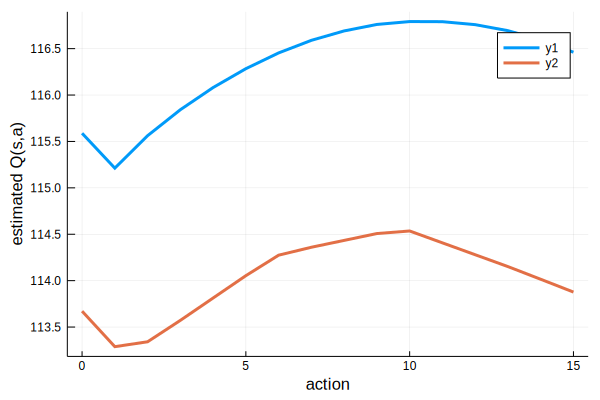

In [335]:
s = 0
println([(optimalQ[1+s, 1+a], fittedQ(s, a)) for a in 0:M])

myPlot = plot(0:M, optimalQ[1+s, :], xlabel = "action", ylabel = "optQ(s,a)", lw=3)
plot!(myPlot, 0:M, [fittedQ(s, a) for a in 0:M],  xlabel = "action", ylabel = " estimated Q(s,a)", lw=3)
